<center><h1>InterFaceGAN reimplementation</h1></center>

This notebook contains a reimplementation of InterFaceGAN. It uses datasets generated by the notebook `ImageGenerator.ipynb` and labelled using a discriminator network trained on the CelebA dataset for 40 attributes (notebook `ImageDiscriminator.ipynb`).

Imports, and mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install StyleGAN2-ada-pytorch dependencies

In [ ]:
# This pip install avoids warnings.
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


In [ ]:
import json
import torch, pickle
import functools

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm


# Retrieving StyleGAN2

In order to edit the images, we need the StyleGAN2 model. This notebook assumes that stylegan2-ada-pytorch and the FFHQ pretrained weights are present in your Google Drive. If this is not the case, go to Part 1 of ImageGenerator.ipynb to download them.

cd to YOUR PATH TO stylegan2-ada-pytorch

Gurvan's path: /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

Victor's path: /content/drive/MyDrive/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

In [ ]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch


In [ ]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
if device_name == "cpu":
  G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)

# Retrieving labeled latent vectors

**Adjust to your setup:** Paths to labels JSON file and archive containing latent vectors

In [ ]:
attribute_number = 31
Victor = False

if Victor:
  latent_vectors_path = '/content/drive/MyDrive/Projet_IIN/InterFaceGAN/ImageLatentCodes.tar.gz'
  labels_path = f'/content/drive/MyDrive/Projet_IIN/InterFaceGAN/Labels/att{str(attribute_number)}_labels.json'
else :
  latent_vectors_path = '/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/ImageLatentCodes.tar.gz'
  labels_path = f'/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/Labels/att{str(attribute_number)}_labels.json'


The following cell copies the latent vectors on the local machine as it would be much slower to manipulate vectors stored in Google Drive.

Around 4min on Colab GPU with 15k tensors.

In [ ]:
%cd /content

/content


In [ ]:
!tar zxvf {latent_vectors_path}

Streaming output truncated to the last 5000 lines.
ImageLatentCodes/tensor11315.pt
ImageLatentCodes/tensor13775.pt
ImageLatentCodes/tensor239.pt
ImageLatentCodes/tensor3695.pt
ImageLatentCodes/tensor13340.pt
ImageLatentCodes/tensor5522.pt
ImageLatentCodes/tensor12718.pt
ImageLatentCodes/tensor9125.pt
ImageLatentCodes/tensor2749.pt
ImageLatentCodes/tensor12795.pt
ImageLatentCodes/tensor1716.pt
ImageLatentCodes/tensor3449.pt
ImageLatentCodes/tensor12082.pt
ImageLatentCodes/tensor4815.pt
ImageLatentCodes/tensor11645.pt
ImageLatentCodes/tensor2105.pt
ImageLatentCodes/tensor10308.pt
ImageLatentCodes/tensor12097.pt
ImageLatentCodes/tensor11686.pt
ImageLatentCodes/tensor5817.pt
ImageLatentCodes/tensor11048.pt
ImageLatentCodes/tensor11890.pt
ImageLatentCodes/tensor13183.pt
ImageLatentCodes/tensor7468.pt
ImageLatentCodes/tensor2407.pt
ImageLatentCodes/tensor366.pt
ImageLatentCodes/tensor7073.pt
ImageLatentCodes/tensor223.pt
ImageLatentCodes/tensor2896.pt
ImageLatentCodes/tensor505.pt
ImageLaten

In [ ]:
# Load the labels
with open(labels_path, 'r') as f:
  labels_dict = json.load(f)

num_samples = len(labels_dict)
dim = 512
Z = torch.zeros((num_samples, dim)).to(device)
y = np.zeros(num_samples, dtype=int)

for i, (filename, label) in tqdm(enumerate(labels_dict.items())):
  sample_number = int(filename[3:-4])
  tensor_path = f'/content/ImageLatentCodes/tensor{sample_number}.pt'
  Z[i] = torch.load(tensor_path, map_location=device)
  y[i] = label

3000it [00:01, 2349.25it/s]


# SVM

In the $\mathcal{Z}$ latent space

In [ ]:
from sklearn.svm import LinearSVC

Z_for_SVM = Z.cpu().numpy()

# Create and train the LinearSVC model
linear_svm_Z = LinearSVC()
linear_svm_Z.fit(Z_for_SVM, y)

# Get the orthogonal vector of the hyperplane made by the svm.
class_direction_Z = torch.Tensor(linear_svm_Z.coef_[0]) # a priori le vecteur est orienté de class 1 vers class 2

Z_intercept = torch.Tensor(linear_svm_Z.intercept_)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In the $\mathcal{W}$ latent space

In [ ]:
W = G.mapping(Z, None)

W_for_SVM = W[:,0,:].cpu().numpy()

linear_svm_W = LinearSVC()
linear_svm_W.fit(W_for_SVM, y)

class_direction_W = torch.Tensor(linear_svm_W.coef_[0])

W_intercept = torch.Tensor(linear_svm_W.intercept_)

Saving the normal vectors and intercepts

In [ ]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN

/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN


In [ ]:
torch.save(class_direction_Z, f'SVM_vectors/class_direction_Z_on_3k_att{attribute_number}.pt')
torch.save(class_direction_W, f'SVM_vectors/class_direction_W_on_3k_att{attribute_number}.pt')

torch.save(Z_intercept, f'SVM_vectors/Z_intercept_on_3k_att{attribute_number}.pt')
torch.save(W_intercept, f'SVM_vectors/W_intercept_on_3k_att{attribute_number}.pt')

# Grouping tensors by label

Here it is on training data but ideally should be on a new dataset (this is done in GANsBenchmarking.ipynb).

In [ ]:
# Sorting Z latent vectors
class_1_tensors_Z = []
class_2_tensors_Z = []

for tensor, label in zip(Z, y) :
  if label == 1 : class_1_tensors_Z.append(tensor)
  elif label == -1 : class_2_tensors_Z.append(tensor)

#print(f"{len(class_1_tensors_Z)} + {len(class_2_tensors_Z)}, {len(Z)}")

assert len(class_1_tensors_Z) + len(class_2_tensors_Z) == len(Z), f"{len(class_1_tensors_Z)} + {len(class_2_tensors_Z)}, {len(Z)}"

# Converting to tensors

class_1_tensors_Z =  torch.stack(class_1_tensors_Z, dim=1)
class_2_tensors_Z =  torch.stack(class_2_tensors_Z)

# Sorting W latent vectors
class_1_tensors_W = []
class_2_tensors_W = []

for tensor, label in zip(W,y) :
  if label == 1 : class_1_tensors_W.append(tensor)
  elif label == -1 : class_2_tensors_W.append(tensor)

# Converting to tensors

class_1_tensors_W = torch.stack(class_1_tensors_W)
class_2_tensors_W = torch.stack(class_2_tensors_W)

# Edit function AllLayers and Layerwise.




In [ ]:
def IFGAN_AllLayersEdition(tensors_for_edition, direction, class_direction, b, G, n_steps_var = 7, scale_factor = 1., save=False):
  """
  Edition of images by editing in the latent space Z with InteFaceGAN method,
  i.e. by going in the opposite direction from the orthogonal vector of the hyperplane that separates class_1 and class_2 tensors.

  z: latent vectors
  direction: going to the class -1 or to the class 1
  class_direction: orthogonal vector of the hyperplane made by a linear svm on the data.
  b: corresponds to the attribute intercept_ of the hyperplane, i.e. the position of the hyperplane.
  G: Generator network of StyleGAN2.
  scale_factor: Scale the power of the changes.

  """
  #if len(tensors_for_edition.shape) < 3 : tensors_for_edition = tensors_for_edition[:, None,:].repeat(repeats = 18, axis = 1)
  nb_img = len(tensors_for_edition)

  steps = torch.linspace(0.0, 1.0, n_steps_var)*scale_factor

  fig = plt.figure(figsize=(2*n_steps_var, 2*nb_img))
  grid = ImageGrid(fig, 111, nrows_ncols=(nb_img, n_steps_var), axes_pad=0.1)

  norm = torch.norm(class_direction)

  for i_img, tensor in enumerate(tensors_for_edition) :
    for istep in range(n_steps_var):
        tensor_transformed = tensor.clone()

        distance = -(torch.dot(class_direction, tensor[0]) +b)/norm**2 # in order to move the tensor onto the hyperplane.

        tensor_transformed += class_direction*distance + steps[istep]*class_direction*direction
        tensor_transformed = tensor_transformed.to(device)

        img = G.synthesis(tensor_transformed[None, :, :]).cpu().detach().numpy()[0].transpose((1,2,0)) # synthesis needs shape (batch, 18, 512)
        img = (img+1)/2
        iplot = i_img*n_steps_var + istep
        if istep==0 :
          grid[iplot].set_ylabel(f"$\\mathrm{{IFG}}(\mathbf{{v}}_{{ att = {attribute_number}}}, \\mathrm{{all}})$", rotation = 0, size = 'x-large')
          grid[iplot].yaxis.set_label_coords(-0.5,0.45)

        grid[iplot].imshow(np.clip((255*img).astype(int), 0, 255))
        grid[iplot].set_yticklabels([])
        grid[iplot].set_xticklabels([])
        grid[iplot].set_xticks([])
        grid[iplot].set_yticks([])
  plt.title = (f"{scale_factor=}")
  plt.legend()
  plt.show()
  if save:
    fig.savefig("all_components.pdf")

# Editing in $\mathcal{W}$

In [ ]:
class_direction_W = class_direction_W.to(device)
class_direction_Z = class_direction_Z.to(device)

W_intercept = W_intercept.to(device)
Z_intercept = Z_intercept.to(device)


In [ ]:
# Choosing random images :
nb_img = 5

# For label 1 :
randidx1 = np.random.choice(range(class_1_tensors_W.shape[0]), nb_img)
tensors1_for_editionW = class_1_tensors_W[randidx1].to(device)
# For label -1 :
randidx2 = np.random.choice(range(class_2_tensors_W.shape[0]), nb_img)
tensors2_for_editionW = class_2_tensors_W[randidx2].to(device)


All-layers editing:

In [ ]:
torch.save(tensors2_for_editionW[3], 'maxime_chauve.pt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
IFGAN_AllLayersEdition(tensors2_for_editionW, 1, class_direction_W, W_intercept, G, scale_factor=2.)

Output hidden; open in https://colab.research.google.com to view.

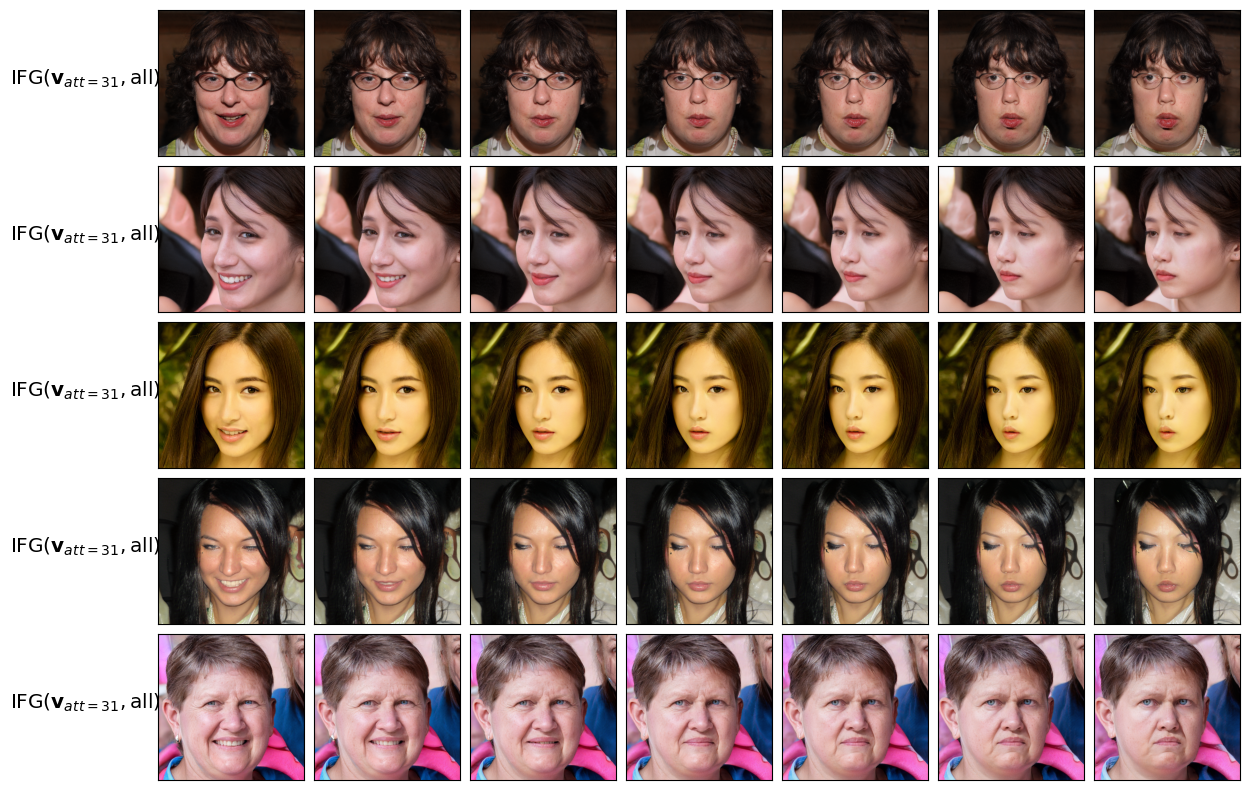

In [ ]:
# For label 1 :
IFGAN_AllLayersEdition(tensors1_for_editionW, -1, class_direction_W, W_intercept, G, scale_factor=1.)

Layerwise editing:

In [ ]:
def layer_group_to_string(group):
  if len(group) >= 2 and list(group) == list(range(min(group), max(group)+1)):
    return f"{min(group)}-{max(group)}"
  else:
    return "\\{" + (",".join(map(str, group))) + "\\}"

def IFGAN_LayerWiseEdition(tensor_for_edition, label, class_direction, G, layer_groups: list = None, n_steps_var = 7, scale_factor = 1., save=False):
  """
  Do a layer-wise change along the class_direction from the SVM.

  layer_groups : Default corresponds to groups of Figure 3 of StyleGAN paper (2019)
  i.e. Core styles (layers 1-4); Middle styles (5-9); Fine styles (10-18)
  """

  if layer_groups is None :
    layer_groups = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]

  n_plot = len(layer_groups)

  steps = torch.linspace(-1.0, 1.0, n_steps_var)*scale_factor

  #if label == -1 : class_direction = -class_direction

  fig = plt.figure(figsize=(2*n_steps_var, 2*n_plot))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_plot, n_steps_var), axes_pad=0.1)

  for i, group in enumerate(layer_groups):
    for istep in range(n_steps_var):
        tensor_transformed = tensor_for_edition.clone()
        tensor_transformed[:, group, :] += steps[istep]*class_direction
        tensor_transformed = tensor_transformed.to(device)

        img = G.synthesis(tensor_transformed = tensor_transformed.to(device)).cpu().detach().numpy()[0].transpose((1, 2, 0))
        img = 255 * (img + 1) / 2
        img = np.clip(img.astype(int), 0, 255)
        iplot = i * n_steps_var + istep

        if istep==0 :
          grid[iplot].set_ylabel(f"$\\mathrm{{IFG}}(\mathbf{{v}}_{{att = {attribute_number}}}, {layer_group_to_string(group)})$", rotation = 0, size = 'x-large')
          grid[iplot].yaxis.set_label_coords(-0.5,0.45)

        grid[iplot].imshow(img)
        grid[iplot].set_yticklabels([])
        grid[iplot].set_xticklabels([])
        grid[iplot].set_xticks([])
        grid[iplot].set_yticks([])

  plt.show()
  if save:
    fig.savefig("layerwise.pdf")

In [ ]:
IFGAN_LayerWiseEdition(tensors1_for_editionW[0], 1, class_direction_W, G)

In [ ]:
IFGAN_LayerWiseEdition(tensors1_for_editionW[0], 2, class_direction_W, G)